# Титаник
**Источник:** <br>https://www.kaggle.com/competitions/titanic/overview
<br>
<br>
**Цели:**
<br>
● построить модель, позволяющую по имеющимся параметрам предсказать выживет или нет пассажир Титаника.
<br>
<br>
**Задачи:** <br>● Подготовить данные к построению модели
<br>
● Построить модель
<br>
**Входные данные:** <br>входные данные представляют собой файл csv, содержащий в себе информацию о пасажирах титаника
<br>
<br>
**Используемые библиотеки:** <br>pandas
<br>numpy
<br>re
<br>matplotlib
<br>seaborn
<br>sklearn
<br>
Для начала импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split


Считаем файл

In [2]:
df = pd.read_csv("train.csv")

Выведем основную информацию о файле

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


891 строк и 12 столбцов. ТИпы данных совпадают с информацией в каждом соответсвующем столбце. Посмотрим на сам датасет

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Приведем названия столбцов к snake_case

In [5]:
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', "_").str.lower()

/var/folders/rt/mvnmln8j70d9fmnh5b6pl1qr0000gn/T/ipykernel_24668/1081600409.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', "_").str.lower()


Проверим на пропуски:

In [6]:
df.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
name            0.000000
sex             0.000000
age             0.198653
sib_sp          0.000000
parch           0.000000
ticket          0.000000
fare            0.000000
cabin           0.771044
embarked        0.002245
dtype: float64

Видим, что пропуски находяться в тех столбцах, где не удасться основываясь на остальных данных предполодить значение (имя, номер кабины...) Пустые значения в столбце cabin заменим на 0

In [7]:
df['cabin'] = df['cabin'].fillna("0")

Выкинем лишние столбцы (или те, которые не сможем привести к числовому виду для построения модели)

In [8]:
df = df.drop(["passenger_id"], axis=1)
df = df.drop(["name"], axis=1)
df = df.drop(["cabin"], axis=1)
df = df.drop(["ticket"], axis=1)


Проверим на неявные дубликаты

In [9]:
df["sex"].value_counts()

male      577
female    314
Name: sex, dtype: int64

In [10]:
df["survived"].value_counts()

0    549
1    342
Name: survived, dtype: int64

In [11]:
df["pclass"].value_counts()

3    491
1    216
2    184
Name: pclass, dtype: int64

Построим диаграммы размаха, чтобы избавиться от выбросов

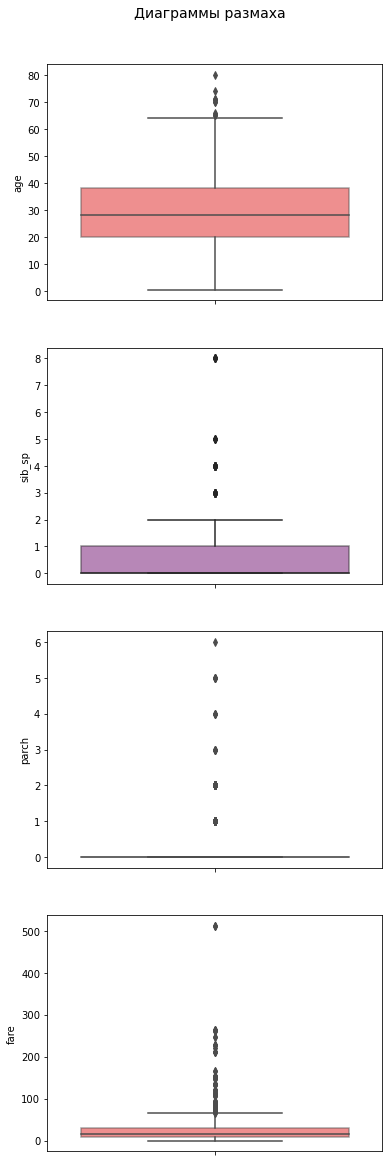

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(6, 20))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("Диаграммы размаха", fontsize=14, y=0.92)

def painting(column, col, axs):
    """
    Функция получает на вход столбец, цвет и позицию, рисует диаграмму размаха по полученным данным
    """
    sns.boxplot(y=df[column], color= col, ax = axs,  boxprops=dict(alpha=.5))
    
    
column = ["age", "sib_sp", "parch", "fare"]
col = ["red", "purple", "gold", "red", "purple", "gold", "red", "purple", "gold", "red", "purple", "gold"]
for i in range(len(column)): 
    painting(column[i], col[i], axs[i])

Уберем выбросы:

In [13]:
Q1 =  df["age"].quantile(0.4)
Q3 = df["age"].quantile(0.8)
IQR = Q3 - Q1
df = df.query("@Q1 - 1.5*@IQR < age < @Q3 + 1.5*@IQR")

Q1 =  df["parch"].quantile(0.3)
Q3 = df["parch"].quantile(0.8)
IQR = Q3 - Q1
df = df.query("@Q1 - 1.5*@IQR < parch < @Q3 + 1.5*@IQR")

Q1 =  df["fare"].quantile(0.3)
Q3 = df["fare"].quantile(0.7)
IQR = Q3 - Q1
df = df.query("@Q1 - 1.5*@IQR < fare < @Q3 + 1.5*@IQR")

Повторно построим диаграммы размаха и проверим, что стало с выбросами

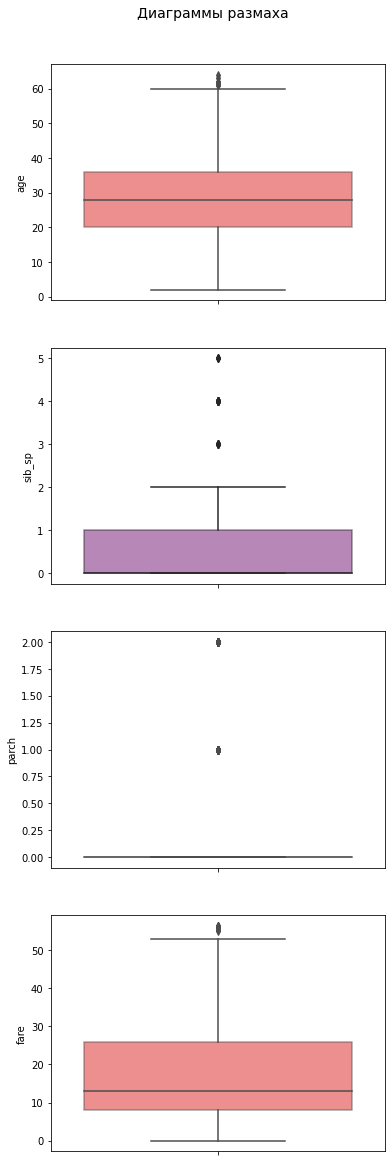

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(6, 20))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("Диаграммы размаха", fontsize=14, y=0.92)

def painting(column, col, axs):
    """
    Функция получает на вход столбец, цвет и позицию, рисует диаграмму размаха по полученным данным
    """
    sns.boxplot(y=df[column], color= col, ax = axs,  boxprops=dict(alpha=.5))
    
    
column = ["age", "sib_sp", "parch", "fare"]
col = ["red", "purple", "gold", "red", "purple", "gold", "red", "purple", "gold", "red", "purple", "gold"]
for i in range(len(column)): 
    painting(column[i], col[i], axs[i])

Стало лучше (мне не удалось убрать все из-за небольшого объема датасета). Преобразую категориальные признаки в численные

In [15]:
df = pd.get_dummies(df, columns=['sex'], drop_first= True)
df = pd.get_dummies(df, columns=['embarked'], drop_first= True)
df = pd.get_dummies(df, columns=['sib_sp'], drop_first= True)
df = pd.get_dummies(df, columns=['parch'], drop_first= True)
df = pd.get_dummies(df, columns=['pclass'], drop_first= True)


Выведу получившийся дата сет

In [16]:
df.head()

,survived,age,fare,sex_male,embarked_Q,embarked_S,sib_sp_1,sib_sp_2,sib_sp_3,sib_sp_4,sib_sp_5,parch_1,parch_2,pclass_2,pclass_3
0,0,22.0,7.2500,1,0,1,1,0,0,0,0,0,0,0,1
2,1,26.0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,0,0,1,1,0,0,0,0,0,0,0,0
4,0,35.0,8.0500,1,0,1,0,0,0,0,0,0,0,0,1
6,0,54.0,51.8625,1,0,1,0,0,0,0,0,0,0,0,0


Выделю признаки и целевой признак.

In [17]:
target = df["survived"]
features = df.drop(["survived"], axis=1)

Считаю файл на котором буду тестировать модель

In [18]:
df1 = pd.read_csv("test.csv")

Для удобства и там приведу названия столбцов к snake_case

In [19]:
df1.columns = df1.columns.str.replace(r'(?<!^)(?=[A-Z])', "_").str.lower()

/var/folders/rt/mvnmln8j70d9fmnh5b6pl1qr0000gn/T/ipykernel_24668/3011722412.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df1.columns = df1.columns.str.replace(r'(?<!^)(?=[A-Z])', "_").str.lower()


Выведу датасет

In [20]:
df1.head()

,passenger_id,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Построим модель и посчитаем метрику f1:

In [21]:
np.random.seed(31415)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25)

In [22]:
model = LogisticRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
x = f1_score(target_valid, predictions_valid)
print(x)

0.6888888888888888


/Users/anastasiakula/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Вывод
В процессе небольшой предобработки я главным образом убрала выбросы с помощью построения диаграмм размаха. По результатам построения модели, метрика f1 получилась достаточно близкой к 1, что хорошо. Но мне не удалось использовать файл с тестовыми данными для проверки модели. Я просто отделила 25 процентов, так как я не поняла, как задавать target для второго датасета, ведь там нет столбца "survived". Получается, в таком случае, сравнивать будет не с чем. То есть features_valid = df1, но вот target_valid = ?